# Explaining Outcomes from Black Box Models

This notebook demonstrates how SLISE can be used to explain outcomes from black box models.

## Prerequisites

The example in this notebook assumes that SLISE is installed, which can be done with:
```sh
pip install https://github.com/edahelsinki/pyslise
```
We also need Keras (Tensorflow) for the neural network:

In [2]:
import numpy as np
from tensorflow import keras
import slise
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [10, 6]

## Dataset

The dataset is the boston housing dataset with 13 variables where the task is to predict the median value of homes in different areas.

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.boston_housing.load_data()
variables = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"]

The meaning of the variables are:

| Variable | Description |
|----------|-------------|
| CRIM     | per capita crime rate by town |
| ZN       | proportion of residential land zoned for lots over 25,000 sq.ft. |
| INDUS    | proportion of non-retail business acres per town |
| CHAS     | Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) |
| NOX      | nitric oxides concentration (parts per 10 million) |
| RM       | average number of rooms per dwelling |
| AGE      | proportion of owner-occupied units built prior to 1940 |
| DIS      | weighted distances to five Boston employment centres |
| RAD      | index of accessibility to radial highways |
| TAX      | full-value property-tax rate per $10,000 |
| PTRATIO  | pupil-teacher ratio by town |
| B        | 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town |
| LSTAT    | % lower status of the population |

The response is the median value of owner-occupied homes in $1000's.

## Model

As the black box model we use a simple neural network with three hidden layers, ReLU activations, batch normalisation, and dropout.

In [4]:
model = keras.Sequential(
    [
        keras.Input(shape=13),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                448       
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3

In [5]:
model.compile(loss = "mean_squared_error", optimizer="adam")
model.fit(x_train, y_train, batch_size=64, epochs=16, validation_split=0.1)
print("Test loss:", model.evaluate(x_test, y_test))

Epoch 1/16
6/6 [==============================] - 0s 20ms/step - loss: 567.3238 - val_loss: 395.7845
Epoch 2/16
6/6 [==============================] - 0s 3ms/step - loss: 527.2925 - val_loss: 387.5147
Epoch 3/16
6/6 [==============================] - 0s 2ms/step - loss: 496.7520 - val_loss: 380.1077
Epoch 4/16
6/6 [==============================] - 0s 3ms/step - loss: 465.4839 - val_loss: 372.7859
Epoch 5/16
6/6 [==============================] - 0s 2ms/step - loss: 434.4547 - val_loss: 365.9541
Epoch 6/16
6/6 [==============================] - 0s 3ms/step - loss: 409.1396 - val_loss: 360.5210
Epoch 7/16
6/6 [==============================] - 0s 3ms/step - loss: 369.1286 - val_loss: 356.9594
Epoch 8/16
6/6 [==============================] - 0s 3ms/step - loss: 345.3490 - val_loss: 357.1227
Epoch 9/16
6/6 [==============================] - 0s 3ms/step - loss: 297.8338 - val_loss: 357.6797
Epoch 10/16
6/6 [==============================] - 0s 2ms/step - loss: 286.8131 - val_loss: 359.302

## Explanation

To create the explanation we instruct SLISE to use normalisation, since the variables have widely different magnitudes. This also enables us to use L1 regularisation to create sparser explanations. (The warnings about maximum steps are usually not that serious and can be ignored.)

In [6]:
item = 3
explanation = slise.explain(x_train, y_train, 0.3, item, lambda1=0.5, normalise=True)

C:\Users\anton\miniconda3\envs\slise\lib\site-packages\slise\optimisation.py:190: SliseWarning: An optimisation step reaches the maximum number of iterations.
  warn(
C:\Users\anton\miniconda3\envs\slise\lib\site-packages\lbfgs\__init__.py:202: UserWarning: The line-search routine reaches the maximum number of evaluations.
  return opt.minimize(f, x0, progress=progress, args=args)


One of the big advantages of SLISE is that it not only considers the model, but also the dataset. To further this investigation we also plot the distributions of the dataset, and compare the explained item to the rest of the dataset. Furthermore, we have the concept of "impact", which is the (normalised) explained items times the (normalised) approximating model. This allows us to manually reconstruct the prediction by summing together the impacts.

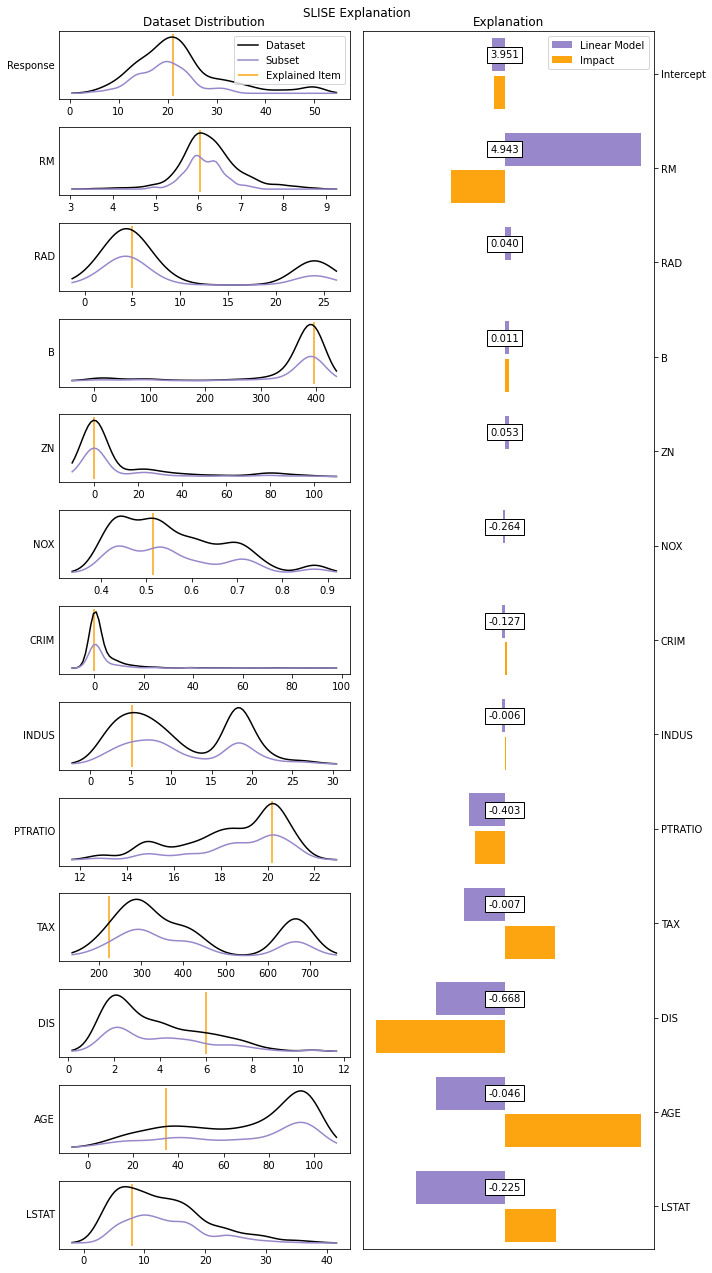

In [7]:
explanation.plot_dist(variables=variables, fig=plt.figure(figsize=(10, 18)))
plt.show()

Based on the linear model we can see that the number of rooms (RM) have a large effect on the value. However, this particular location has a very average number of rooms per dwelling, so the impact is considerably smaller. On the other hand, the location is quite far away from any employment centre (DIS), so the impact is larger for this particaular location than what the approximating model suggests.

The variables TAX, AGE, and LSTAT have a negative effect on the home value (according to the linear approximation). But the particular location being explained have lower values for these variables, so these are actually indicators of a higher home value. This "double negative" is represented by a positive weight 
in the impact.